In [1]:
import sys
sys.path.append('..')

In [2]:
from project.model import *
from project.utils import *
from project.cost_functions import *
from project.strategy import *

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# used ideas and code from https://github.com/staretgicclfdark/strategic_rep
'''
Todo:
 - (DONE) Cost function (w/ convex solver)
 - (DONE) Hardt model
 - (DONE) Generate data
 - (DONE) Strategic agents
 - (DONE) Strategic agents in the dark
  + Friend network/dictionary
  + Local model estimation
 - (DONE) Plot changes w/ arrows
'''

'''
More todos:
 - Plot estimated decision boundaries for some points
 - Move plot functionality to 'plot.py' files
 - Implement counterfactuals and going by rounds
 - Run several experiments with different sizes for m
'''

In [3]:
model = HardtModel(LinearCost(a=np.array([1,1])))
data = create_dataset(500, d = 2)
model.fit(data[['f0', 'f1']], data['target'])

100%|██████████| 500/500 [00:04<00:00, 104.30it/s]


In [4]:
n = 100
featurelist = ['f0', 'f1']
m = 10
a = np.array([1,1])
epsilon = 0.3
next = create_dataset(n, d = 2)
cost = MixedCost(a = a, epsilon=epsilon)
fd = generate_friend_dict(df = next,
                          m = m,
                          featurelist = featurelist,
                          model = model)
fd100 = generate_friend_dict(df=next,
                             m=100,
                             featurelist=featurelist,
                             model=model)
rnd_fd = generate_random_friends_dict(df = next,
                                      m = m)
players = np.arange(n)
dark, dark_train, dark_fhat = strategy_dark(original_df=next,
                                            featurelist=featurelist,
                                            model=model,
                                            cost=cost,
                                            friends_dict=fd,
                                            players=players)
full_info = strategy_light(next, model, featurelist, cost, players)
dark100, dark_train100, dark_fhat100 = strategy_dark(original_df=next,
                                                     featurelist=featurelist,
                                                     model=model,
                                                     cost=cost,
                                                     friends_dict=fd100,
                                                     players=players)

100%|██████████| 100/100 [00:01<00:00, 56.39it/s]


In [ ]:
explained, exp_train, exp_fhat = strategy_with_explanations(original_df=next,
                                                            model=model,
                                                            featurelist=featurelist,
                                                            cost=cost,
                                                            friends_dict=fd,
                                                            players=players)
explained_rnd, exp_rnd_train, exp_rnd_fhat = strategy_with_explanations(original_df=next,
                                                                        model=model,
                                                                        featurelist=featurelist,
                                                                        cost=cost,
                                                                        friends_dict=rnd_fd,
                                                                        players=players)

In [6]:
dark_df = next.copy()
dark_df['f0_after'] = dark['f0']
dark_df['f1_after'] = dark['f1']
dark_df = dark_df.astype({'target': 'category'})

dark100_df = next.copy()
dark100_df['f0_after'] = dark100['f0']
dark100_df['f1_after'] = dark100['f1']
dark100_df = dark100_df.astype({'target': 'category'})

full_df = next.copy()
full_df['f0_after'] = full_info['f0']
full_df['f1_after'] = full_info['f1']
full_df = full_df.astype({'target': 'category'})

def plot_sim(plot_df, model):
    sns.set_style('whitegrid')
    sns.set_context('talk')
    ax = plt.figure(figsize = (10,10))
    ax = sns.scatterplot(data=plot_df, x='f0', y='f1', hue='target', palette=sns.color_palette('tab10')[:2])
    for i in range(len(plot_df)):
        if plot_df['f0_after'].loc[i] - plot_df['f0'].loc[i] < 0.05:
            continue
        ax.arrow(x=plot_df['f0'].loc[i],
                 y=plot_df['f1'].loc[i],
                 dx=plot_df['f0_after'].loc[i] - plot_df['f0'].loc[i],
                 dy=plot_df['f1_after'].loc[i] - plot_df['f1'].loc[i],
                 width=0.005,
                 head_width=0.05,
                 head_length=0.05,
                 color='red',
                 alpha=0.5)
    t = np.arange(-2, 4, 0.2)
    plt.plot(t, -t - model.intercept_, zorder=0, label='Strategic')
    plt.plot(t, -t - model.intercept_ - 2, '--', zorder=0, label='Non-strategic')
    plt.xlim(-2, 2.5)
    plt.ylim(-2, 2.5)

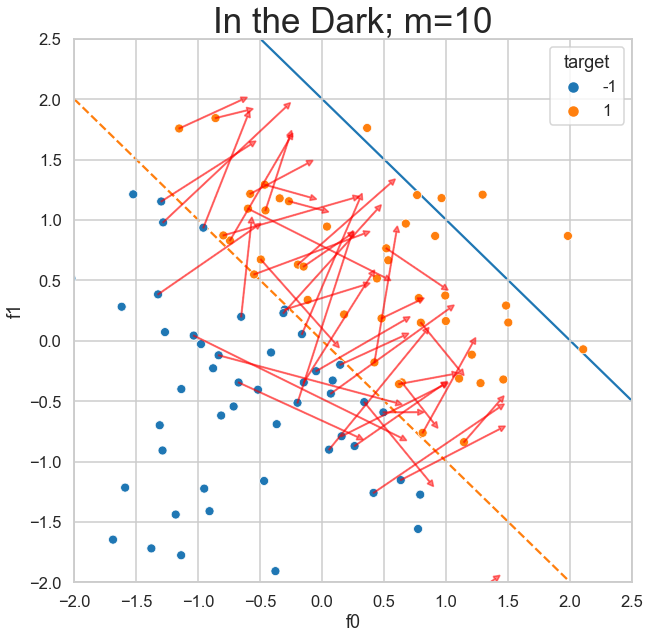

In [13]:
plot_sim(dark_df, model)
plt.title('In the Dark; m=10', fontsize=35)
plt.savefig('dark.png')

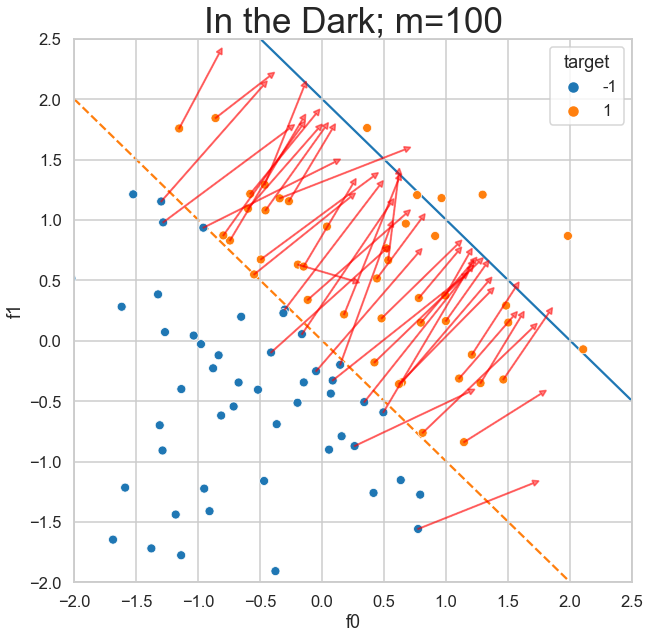

In [14]:
plot_sim(dark100_df, model)
plt.title('In the Dark; m=100', fontsize=35)
plt.savefig('dark100.png')

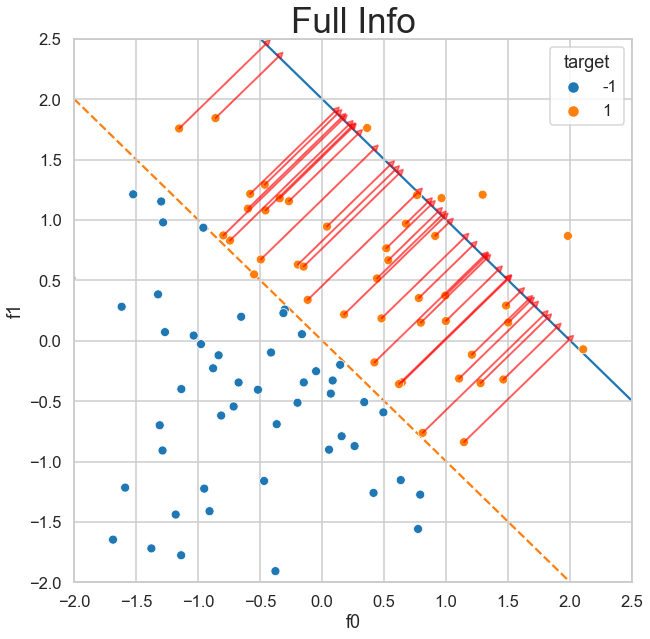

In [15]:
plot_sim(full_df, model)
plt.title('Full Info', fontsize=35)
plt.savefig('full.png')

In [ ]:
sns.set_style('whitegrid')
sns.set_context('talk')
ax = plt.figure(figsize=(10, 10))
ax = sns.scatterplot(data = plot_df, x = 'f0', y = 'f1', hue = 'target', palette = sns.color_palette('tab10')[:2])
for i in range(len(plot_df)):
    if plot_df['f0_after'].loc[i] - plot_df['f0'].loc[i] < 0.05:
        continue
    ax.arrow(x = plot_df['f0'].loc[i],
             y = plot_df['f1'].loc[i],
             dx = plot_df['f0_after'].loc[i] - plot_df['f0'].loc[i],
             dy = plot_df['f1_after'].loc[i] - plot_df['f1'].loc[i],
             width = 0.005,
             head_width = 0.05,
             head_length = 0.05,
             color = 'red',
             alpha = 0.5)
t = np.arange(-2, 3, 0.2)
plt.plot(t, -t - model.intercept_, zorder=0)
plt.plot(t, -t - model.intercept_-2, '--', zorder=0)

In [19]:
plot_df = next.copy()
plot_df['f0_after'] = explained['f0']
plot_df['f1_after'] = explained['f1']
plot_df = plot_df.astype({'target': 'category'})

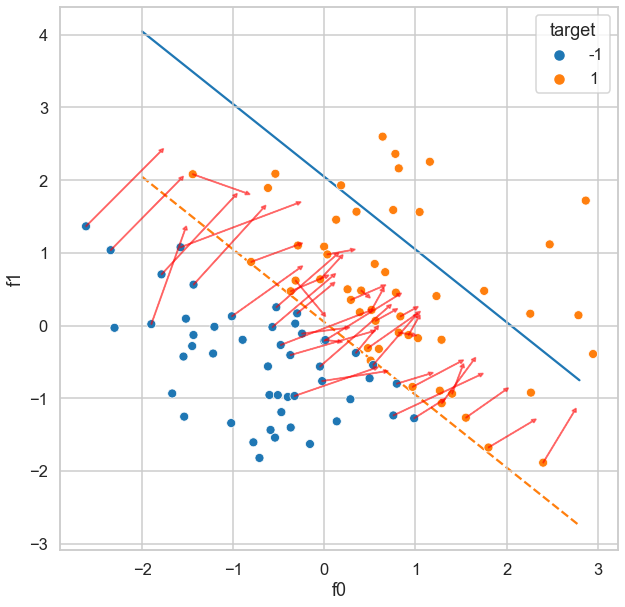

In [20]:
sns.set_style('whitegrid')
sns.set_context('talk')
ax = plt.figure(figsize=(10, 10))
ax = sns.scatterplot(data = plot_df, x = 'f0', y = 'f1', hue = 'target', palette = sns.color_palette('tab10')[:2])
for i in range(len(plot_df)):
    if plot_df['f0_after'].loc[i] - plot_df['f0'].loc[i] < 0.05:
        continue
    #plt.plot(t*exp_fhat[i].coef_[0][0], -t*exp_fhat[i].coef_[0][1] - exp_fhat[i].intercept_, 'b--', zorder=0)
    ax.arrow(x = plot_df['f0'].loc[i],
             y = plot_df['f1'].loc[i],
             dx = plot_df['f0_after'].loc[i] - plot_df['f0'].loc[i],
             dy = plot_df['f1_after'].loc[i] - plot_df['f1'].loc[i],
             width = 0.005,
             head_width = 0.05,
             head_length = 0.05,
             color = 'red',
             alpha = 0.5)
t = np.arange(-2, 3, 0.2)
plt.plot(t, -t - model.intercept_, zorder=0)
plt.plot(t, -t - model.intercept_-2, '--', zorder=0)

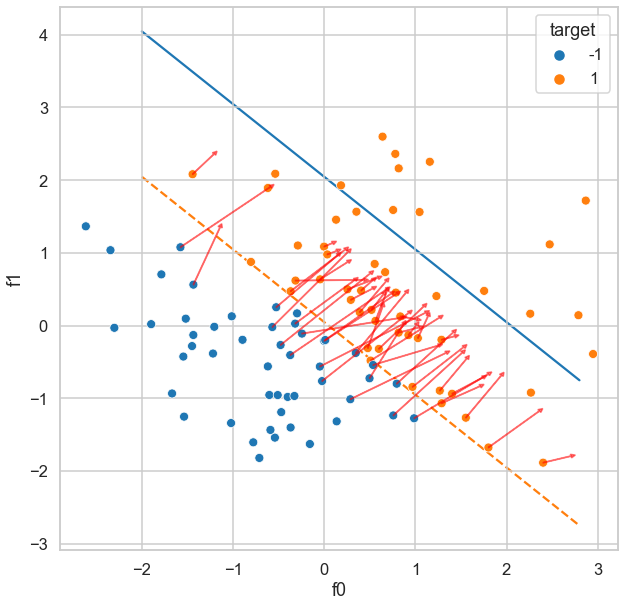

In [21]:
plot_df = next.copy()
plot_df['f0_after'] = explained_rnd['f0']
plot_df['f1_after'] = explained_rnd['f1']
plot_df = plot_df.astype({'target': 'category'})

sns.set_style('whitegrid')
sns.set_context('talk')
ax = plt.figure(figsize=(10, 10))
ax = sns.scatterplot(data = plot_df, x = 'f0', y = 'f1', hue = 'target', palette = sns.color_palette('tab10')[:2])

for i in range(len(plot_df)):
    if plot_df['f0_after'].loc[i] - plot_df['f0'].loc[i] < 0.05:
        continue
    #plt.plot(t*exp_rnd_fhat[i].coef_[0][0], -t*exp_rnd_fhat[i].coef_[0][1] - exp_rnd_fhat[i].intercept_, 'b--', zorder=0)
    ax.arrow(x = plot_df['f0'].loc[i],
             y = plot_df['f1'].loc[i],
             dx = plot_df['f0_after'].loc[i] - plot_df['f0'].loc[i],
             dy = plot_df['f1_after'].loc[i] - plot_df['f1'].loc[i],
             width = 0.005,
             head_width = 0.05,
             head_length = 0.05,
             color = 'red',
             alpha = 0.5)
t = np.arange(-2, 3, 0.2)
plt.plot(t, -t - model.intercept_, zorder=0)
plt.plot(t, -t - model.intercept_-2, '--', zorder=0)

In [19]:
plot_df[plot_df['f0_after'] - plot_df['f0'] > 0.05].index.values

array([ 0,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 16, 17, 22, 27, 28, 30,
       36, 37, 39, 41, 45, 46, 47, 49, 53, 54, 56, 58, 61, 63, 67, 68, 70,
       71, 72, 75, 77, 80, 81, 82, 84, 87, 93, 96, 97, 98])